In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import f1_score


In [5]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
x_train_scaled_df = pd.read_pickle("./x_train_scaled_df.pkl")
y_train = np.load("./y_train.npy")

In [3]:
x_val_scaled_df = pd.read_pickle("./x_val_scaled_df.pkl")
y_val = np.load("./y_val.npy")

In [4]:
x_train = x_train_scaled_df.to_numpy()
x_val = x_val_scaled_df.to_numpy()

In [64]:
x_train_num = x_train[:,2:]
x_train_num = np.array(x_train_num, dtype=np.float32)
x_val_num = x_val[:,2:]
x_val_num = np.array(x_val_num, dtype=np.float32)

x_train_loan = x_train[:,1]
x_val_loan = x_val[:,1]

x_train_lender = x_train[:,0]
x_val_lender = x_val[:,0]

In [21]:
loan_types_unique_list = list(x_train_scaled_df['loan_type'].unique())
lenders_unique_list = list(x_train_scaled_df['lender_id'].unique())

In [22]:
def embedding_output_dim(input_dim):
    return round((1.6*input_dim)**0.56)

In [23]:
tf.keras.backend.clear_session()

In [24]:
tf.random.set_seed(42)
loan_type_look_up_layer = tf.keras.layers.StringLookup()
loan_type_look_up_layer.adapt(loan_types_unique_list)
lookup_and_embed_loan_type = tf.keras.Sequential([
    loan_type_look_up_layer,
    tf.keras.layers.Embedding(input_dim=loan_type_look_up_layer.vocabulary_size(), output_dim=embedding_output_dim(loan_type_look_up_layer.vocabulary_size())),
    tf.keras.layers.Flatten()
])


I0000 00:00:1736010377.577860    8218 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9899 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:10:00.0, compute capability: 8.6


In [25]:
lender_type_look_up_layer = tf.keras.layers.StringLookup()
lender_type_look_up_layer.adapt(lenders_unique_list)
lookup_and_embed_lender_type = tf.keras.Sequential([
    lender_type_look_up_layer,
    tf.keras.layers.Embedding(input_dim=lender_type_look_up_layer.vocabulary_size(), output_dim=embedding_output_dim(lender_type_look_up_layer.vocabulary_size())),
    tf.keras.layers.Flatten()
])

In [26]:
num_input = tf.keras.layers.Input(shape=[15], name="num")
loan_cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="loan_cat")
lender_cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="lender_cat")

loan_embeddings = lookup_and_embed_loan_type(loan_cat_input)
lender_embeddings = lookup_and_embed_lender_type(lender_cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, loan_embeddings, lender_embeddings])

number_of_neurons_per_layer = 200
number_of_layers_deep = 15
number_of_layers_wide = 0
activation = tf.keras.activations.silu 
kernel_innit = "he_normal"



deep_path = encoded_inputs
for i in range(number_of_layers_deep): 
    deep_path = tf.keras.layers.BatchNormalization()(deep_path)
    deep_path = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=activation, kernel_initializer=kernel_innit)(deep_path)

# Wide path
wide_path = encoded_inputs
for i in range(number_of_layers_wide):  # number_of_layers_wide
    wide_path = tf.keras.layers.BatchNormalization()(wide_path)
    wide_path = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=activation, kernel_initializer=kernel_innit)(wide_path)

# Combine deep and wide paths
concat_layer = tf.keras.layers.concatenate([deep_path, wide_path])

last_dense = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=activation, kernel_initializer=kernel_innit)(concat_layer)

# Output layer
output = tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer=kernel_innit)(last_dense)

# Define the model
model_ = tf.keras.Model(inputs=[num_input, loan_cat_input, lender_cat_input], outputs=output)


In [27]:
learning_rate = 0.001
Optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.005, monitor="val_pr_auc")
Loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.98, gamma=3.0)
Metrics =  [tf.keras.metrics.AUC(name='pr_auc', curve='PR'), tf.keras.metrics.RecallAtPrecision(precision=0.8)]
Batch_Size = 32
Epochs = 50

In [28]:
model_.compile(
    optimizer=Optimizer,  
    loss=Loss,
    metrics=Metrics,
)

In [41]:
history = model_.fit(
    (x_train_num, x_train_loan, x_train_lender),
    y_train,
    callbacks=[early_stop],
    batch_size=Batch_Size,
    epochs=Epochs,
    validation_data=((x_val_num, x_val_loan, x_val_lender), y_val)
)

Epoch 1/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0055 - pr_auc: 0.7174 - recall_at_precision: 0.5334 - val_loss: 0.0119 - val_pr_auc: 0.5521 - val_recall_at_precision: 0.2480
Epoch 2/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - loss: 0.0039 - pr_auc: 0.7970 - recall_at_precision: 0.6179 - val_loss: 0.0052 - val_pr_auc: 0.7854 - val_recall_at_precision: 0.6560
Epoch 3/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0035 - pr_auc: 0.8306 - recall_at_precision: 0.6627 - val_loss: 0.0061 - val_pr_auc: 0.7992 - val_recall_at_precision: 0.5680
Epoch 4/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - loss: 0.0036 - pr_auc: 0.8411 - recall_at_precision: 0.7186 - val_loss: 0.0294 - val_pr_auc: 0.6888 - val_recall_at_precision: 0.4000
Epoch 5/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0031 - pr_auc: 0.8595 - recall_at_precision: 0.7700 - val_loss: 0.0105 - val_pr_auc: 0.7811 - val_recall_at_precision: 0.5120
Epoch 6/50
1931/1931 ━━━━━━━━━━━━━━━━━━━

In [37]:
import matplotlib.pyplot as plt

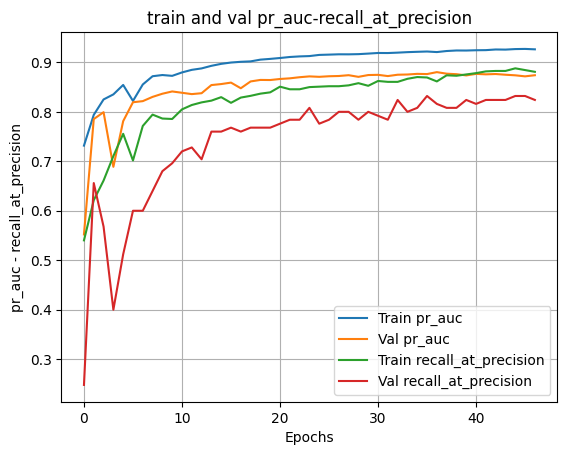

In [43]:
train_pr_auc = history.history['pr_auc']  
val_pr_auc = history.history['val_pr_auc']  

train_recall_at_precision = history.history['recall_at_precision']  
val_recall_at_precision = history.history['val_recall_at_precision']  


plt.plot(train_pr_auc, label='Train pr_auc')
plt.plot(val_pr_auc, label='Val pr_auc')
plt.plot(train_recall_at_precision, label='Train recall_at_precision')
plt.plot(val_recall_at_precision, label='Val recall_at_precision')
plt.xlabel('Epochs')
plt.ylabel('pr_auc - recall_at_precision')
plt.title('train and val pr_auc-recall_at_precision')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#model_.save('model_1.keras')

In [48]:
model_.save('model_2.keras')

In [30]:
model_reload = tf.keras.models.load_model('model_1.keras')

fit into validation data too later !

In [44]:
val_preds = model_.predict((x_val_num, x_val_loan, x_val_lender))

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [45]:
def classify_from_model(preds, threshold):
    return np.where(preds>threshold, 1, 0).astype(int).flatten()

In [46]:
def find_best_threshold(validation_preds, y_validation):
    arr_of_f1s = np.full(shape=(100,),fill_value=0, dtype=float)
    for thres in range(0,100,1):
        arr_of_f1s[thres]= f1_score(y_pred=classify_from_model(validation_preds, thres/100), y_true=y_validation)
    best_f1_index = np.argmax(arr_of_f1s)
    best_f1 = arr_of_f1s[best_f1_index]
    print(f"Best f1 is {round(best_f1,2)} for threshold {best_f1_index}")
    return arr_of_f1s

In [47]:
f1s = find_best_threshold(validation_preds=val_preds, y_validation=y_val)

Best f1 is 0.81 for threshold 42


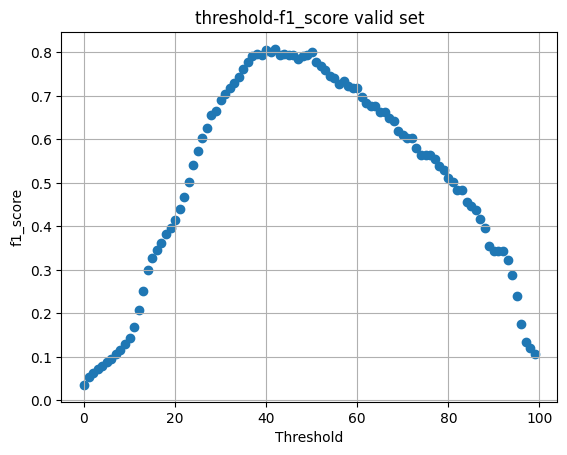

In [49]:
plt.scatter(x=range(100), y=f1s)
plt.xlabel('Threshold')
plt.ylabel('f1_score')
plt.title('threshold-f1_score valid set')
plt.grid(True)
plt.show()

In [5]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score
from functools import partial
from xgboost import XGBClassifier

In [6]:
from skopt import gp_minimize
from skopt import space

ModuleNotFoundError: No module named 'skopt'

In [7]:
x_train_scaled_df[['loan_type', 'lender_id']] = x_train_scaled_df[['loan_type', 'lender_id']].astype("category")
x_train = x_train_scaled_df.copy()

In [8]:
x_val_scaled_df[['loan_type', 'lender_id']] = x_val_scaled_df[['loan_type', 'lender_id']].astype("category")
x_val = x_val_scaled_df.copy()

In [9]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)


In [10]:
scale_pos = sum(y_train==0) / sum(y_train==1)

In [10]:
def optimize_XGB(params, param_names, x, y):
    params= dict(zip(param_names, params))
    kf = StratifiedKFold(n_splits=5)
    auc_scores = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x.loc[train_idx]
        ytrain = y.loc[train_idx]
        
        xtest = x.loc[test_idx]
        ytest = y.loc[test_idx]
        
        
        model = XGBClassifier(**params, scale_pos_weight= scale_pos, enable_categorical=True, device="gpu")
        model.fit(xtrain, ytrain)
        preds = model.predict_proba(xtest)
        winner_one = preds[:, 1]
        auc = roc_auc_score(ytest, winner_one)
        auc_scores.append(auc)
    return -1.0 * np.mean(auc_scores)

param_space_XGB = [
    space.Integer(2, 8, name="max_depth"),
    space.Real(0.001, 1.0, prior="log-uniform" ,name="learning_rate"),
    space.Real(0.1, 1.0, prior="uniform" ,name="subsample"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bytree"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bylevel"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bynode"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_alpha"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_lambda"),
    space.Real(0.0, 15.0, prior="uniform" ,name="gamma"),
    
]
param_names_XGB = [
    "max_depth",
    "learning_rate",
    "subsample",
    "colsample_bytree",
    "colsample_bylevel",
    "colsample_bynode",
    "reg_alpha",
    "reg_lambda",
    "gamma",
   
    
]

optimization_function_XGB = partial(
    optimize_XGB,
    param_names = param_names_XGB,
    x = x_train,
    y = y_train
)

result_XGB =  gp_minimize(
    optimization_function_XGB,
    dimensions = param_space_XGB,
    verbose=10,
    n_calls=100,
)

print(
    dict(zip(param_names_XGB, result_XGB.x))
)

Iteration No: 1 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:26:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1733179782501/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7691
Function value obtained: -0.9943
Current minimum: -0.9943
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.5494
Function value obtained: -0.9944
Current minimum: -0.9944
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4859
Function value obtained: -0.9909
Current minimum: -0.9944
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.3382
Function value obtained: -0.9918
Current minimum: -0.9944
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0533
Function value obtained: -0.9926
Current minimum: -0.9944
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Ev

In [11]:
model_xgb = XGBClassifier(max_depth= 5, learning_rate= 0.145982766680846, subsample= 0.8731995463098501, colsample_bytree= 0.32671033490752127, colsample_bylevel= 0.7649860956775567, colsample_bynode= 1.0, reg_alpha= 0.0, reg_lambda= 10.0, gamma= 1.6561198228345784, scale_pos_weight= scale_pos, enable_categorical=True, device="gpu")

In [12]:
model_xgb.fit(x_train, y_train)

/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:33] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7649860956775567, colsample_bynode=1.0,
              colsample_bytree=0.32671033490752127, device='gpu',
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=1.6561198228345784,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.145982766680846,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
x_val_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']] = x_val_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']].astype(float)

In [30]:
val_preds = model_xgb.predict_proba(x_val_scaled_df)

In [31]:
def classify_from_xgb(preds, threshold):
    return np.where(preds[:,1]>threshold, 1, 0).astype(int).flatten()

In [32]:
def find_best_threshold_xgb(validation_preds, y_validation):
    arr_of_f1s = np.full(shape=(100,),fill_value=0, dtype=float)
    for thres in range(0,100,1):
        arr_of_f1s[thres]= f1_score(y_pred=classify_from_xgb(validation_preds, thres/100), y_true=y_validation)
    best_f1_index = np.argmax(arr_of_f1s)
    best_f1 = arr_of_f1s[best_f1_index]
    print(f"Best f1 is {round(best_f1,2)} for threshold {best_f1_index}")
    return arr_of_f1s

In [33]:
f1s = find_best_threshold_xgb(validation_preds=val_preds, y_validation=y_val)

Best f1 is 0.79 for threshold 91


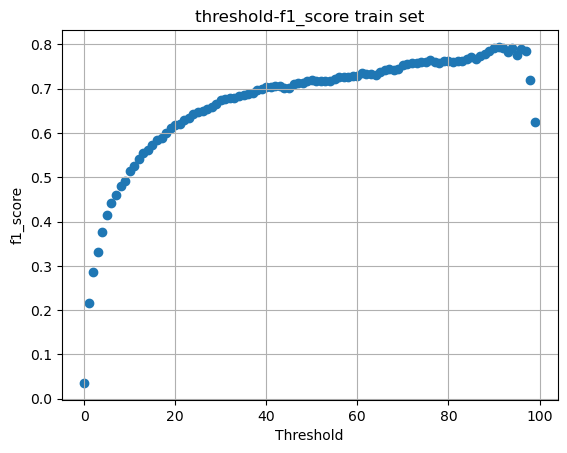

In [38]:
plt.scatter(x=range(100), y=f1s)
plt.xlabel('Threshold')
plt.ylabel('f1_score')
plt.title('threshold-f1_score train set')
plt.grid(True)
plt.show()